<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/P1C1-optimized-agent/sequences/P1C1_BehaviourAsPolicy/P1C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1 Behaviour, Environments and Optimization: Evolution and Learning**

### **Animals are adapted to their specific environments; their behaviour is best understood within the context of their evolutionary environment.**

### Objective: Part 1 of the book aims to introduce the fundamental concepts of
* ### **environment**, where an organism lives;
* ### **behaviour**, what the organism does there;
* ### **optimization**, how learning and evolution shape an organism's behaviour to make it better suited to its environment.

___
# Chapter 1.1 Behaviour as a Policy in an Environmental Context

### Objective: This chapter develops examples of how behaviour is described and evaluated in relation to its [goodness](## "This is a very loaded term, to be unpacked carefully later") within a specific environmental niche.

You will learn:
*   What is a policy? A policy is a formalization of behaviour as a function that takes an organism's experiences of their environment as an input and outputs the organism's actions.
*   What is a good policy? The rewards and other environmental signals, resulting from the organism's actions in the environment, are integrated into a Loss/Objective function to evaluatate, and potentially improve, a policy.
*   What is stochasticity? Both the environment and an organism's behavior can contain random elements. This randomness can pose challenges when evaluating policies, as it becomes difficult to determine whether poor outcomes are due the policy itself or simply bad luck.



___
# **Sequence 1.1.1: Gridworld Introduction**

### Objective: In this sequence, we will create a simple environment-organism system to demonstrate how an organism's **behaviour**, within an **environment**, can be evaluated using **rewards**. We will also explore how intelligent behaviour can lead to better outcomes and how **randomness** can make evaluation of behaviour difficult.

# Setup

You don't need to worry about how the code in the following cells works, but you do need to run these cells, in order.

In [1]:
# @title Dependency Downloads and Installs
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!pip install ipympl vibecheck datatops > /dev/null 2> /dev/null #google.colab

In [2]:
# @title Import Modules
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
import ipywidgets as widgets
import functools
import threading
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import time
import asyncio
import logging
import requests
import io
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import jax
import collections
import math

from tqdm.notebook import tqdm

from vibecheck import DatatopsContentReviewContainer

IN_COLAB = False
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  print('Not running in colab')


Running in colab


In [3]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [4]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
SEED = 2021
set_seed(seed=SEED)
np_rng = np.random.default_rng(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


In [6]:
# @title Plotting Setup and Functions
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

def make_grid(num_rows, num_cols):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for futher use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  fig, ax = plt.subplots(figsize = (7,6), layout='constrained')
  ax.spines[['right', 'top']].set_visible(True)
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Labels for major ticks
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)

  # Minor ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)

  ax.xaxis.tick_top()

  # Gridlines based on minor ticks
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

  # Remove minor ticks
  ax.tick_params(which='minor', bottom=False, left=False)

  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  ax.invert_yaxis()
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()
  return fig, ax

def plot_food(fig, ax, rc_food_loc, food=None):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if food is None:
    food = ax.scatter([], [], s=150, marker='o', color='red', label='Food')
  rc_food_loc = np.array(rc_food_loc, dtype=int)
  #matrix indexing convention is is [row-vertical, col-horizontal]
  #plotting indexing convention is (x-horizontal,y-vertical), hence flip
  food.set_offsets(np.fliplr(rc_food_loc))
  return food

def plot_critter(fig, ax, rc_critter_loc, critter=None):
  """
  Plots "critters" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollenction object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h', color='blue', label='Critter')
  #matrix indexing convention is is [row-vertical, col-horizontal]
  #plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter

In [7]:
from ast import AsyncFunctionDef
# @title Simulation Functions, Variables and widgets
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**


def init_loc(n_rows, n_cols, num):
  """
  Samples random 2d grid locations, without replacement,

  Returns:
    int_loc: ndarray(int) of flat indices for a grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in the way that matplotlib likes
  """
  int_loc = np.random.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.fliplr(np.array(rc_index).T)
  return int_loc, rc_index, rc_plotting




class GridworldBoard():
  """
  A collection methods and parameters of a gridworld game board that
  define the logic of the game.
  Board state is tracked as a triple (pieces, scores, rounds_left)
  pieces: batch_size x n_rows x n_cols np.array
  scores: batch_size np.array
  rounds_left: batch_size np.array

  Pieces are interpreted as:
  1=critter, -1=food, 0=empty

  First dim is batch, second dim row , third is col, so pieces[0][1][7]
  is the square in row 2, in column 8 of the first board in the batch of boards

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """


  def __init__(self, batch_size=1,
               n_rows=7, n_cols=7,
               num_food=10, lifetime=30):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_food = num_food
    self.lifetime = lifetime


  def get_init_board_state(self):
    """Set up starting board using game parameters"""
    #set rounds_left and score
    self.rounds_left = np.ones(self.batch_size) * self.lifetime
    self.scores = np.zeros(self.batch_size)
    # create an empty board array.
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols))
    # Place critter and initial food items on the board randomly
    for ii in np.arange(self.batch_size):
      # num_food+1 because we want critter and food locations
      int_loc, rc_idx, rc_plot = init_loc(self.n_rows,
                                          self.n_cols,
                                          self.num_food+1)
      # critter random start location
      self.pieces[(ii, rc_idx[0][0], rc_idx[1][0])] = 1
      # food random start locations
      self.pieces[(ii, rc_idx[0][1:], rc_idx[1][1:])] = -1
    return(self.pieces.copy(), self.scores.copy(), self.rounds_left.copy())


  def set_state(self, board):
    """ board is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    self.pieces = board[0].copy()
    self.scores = board[1].copy()
    self.rounds_left = board[2].copy()


  def get_state(self):
    """ returns a board state, which is a triple of np arrays
    pieces,       - batch_size x n_rows x n_cols
    scores,       - batch_size
    rounds_left   - batch_size
    """
    return(self.pieces.copy(), self.scores.copy(), self.rounds_left.copy())


  def __getitem__(self, index):
    return self.pieces[index]


  def execute_moves(self, moves):
    """
    Updates the state of the board given the moves made.

    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new x coord for each critter
        on each board and the third gives the new y coord.

    Note:
      Assumes that there is exactly one valid move for each board in the
      batch of boards. i.e. it does't check for bounce/reflection on edges,
      or for multiple move made on the same board. It only checks for eating
      food and adds new food when appropriate. Invalid moves could lead to
      illegal teleporting behavior, critter dublication, or index out of range
      errors.
    This assumes the move is valid, i.e. doesn't check for
    bounce/reflection on edges, it only checks eating and adds new food,
    so invalid moves could lead to illegal teleporting behaviour or index out
    of range errors
    """
    assert len(moves[0]) == self.pieces.shape[0]
    #critters leave their spots
    self.pieces[self.pieces==1] = 0
    #which critters have food in their new spots
    eats_food = self.pieces[moves] == -1
    # some critters eat and their scores go up
    self.scores = self.scores + eats_food

    num_empty_after_eat = self.n_rows*self.n_cols - self.num_food
    # -1 for the critter +1 for food eaten
    # which boards in the batch had eating happen
    g_eating = np.where(eats_food)[0]
    new_food_sample = np_rng.choice(num_empty_after_eat, size=np.sum(eats_food))
    # add random food to replace what is eaten
    if np.any(eats_food):
      possible_new_locs = np.where(np.logical_and(
          self.pieces == 0, #the spot is empty
          eats_food.reshape(self.batch_size, 1, 1))) #food eaten on that board
      food_sample_ = np_rng.choice(num_empty_after_eat, size=np.sum(eats_food))
      food_sample = food_sample_ + np.arange(len(g_eating))*num_empty_after_eat
      assert np.all(self.pieces[(possible_new_locs[0][food_sample],
                                 possible_new_locs[1][food_sample],
                                 possible_new_locs[2][food_sample])] == 0)
      #put new food on the board
      self.pieces[(possible_new_locs[0][food_sample],
                   possible_new_locs[1][food_sample],
                   possible_new_locs[2][food_sample])] = -1
    # put critters in new positions
    self.pieces[moves] = 1.0
    self.rounds_left = self.rounds_left - 1
    assert np.all(self.pieces.sum(axis=(1,2)) == ((self.num_food * -1) + 1))


  def get_legal_moves(self):
    """Identifies all legal moves for the critter, taking into acount
    bouncing/reflection at edges,

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offstet on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    #apply all possible offsets to each game
    moves = np.stack([
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0,  1, 0])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, -1, 0])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, 0,  1])]*self.batch_size).T,
      np.array(np.where(self.pieces == 1)) +
        np.array([np.array([0, 0, -1])]*self.batch_size).T]).swapaxes(0,2)

    #check bounces at boundaries
    moves[:,1,:] = np.where(moves[:,1,:] >=
                            self.n_rows, self.n_rows-2, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] >=
                            self.n_cols, self.n_cols-2, moves[:,2,:])
    moves[:,1,:] = np.where(moves[:,1,:] < 0, 1, moves[:,1,:])
    moves[:,2,:] = np.where(moves[:,2,:] < 0, 1, moves[:,2,:])
    return moves




class GridworldGame():
  """
  A collection methods and parameters of a gridworld game that allow
  for interaction with and display of GridwordlBoard objects.
  """
  square_content = {
      -1: "X", #Food
      +0: "-", #Nothing
      +1: "O"  #Critter
      }


  def get_square_piece(self, piece):
    return GridworldGame.square_content[piece]


  def __init__(self, batch_size, n_rows, n_cols, num_food, lifetime):
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_food = num_food
    self.lifetime = lifetime


  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns a tuple giving current state of the game
    """
    # current score, and rounds left in the episode
    b = GridworldBoard(self.batch_size, self.n_rows, self.n_cols,
                       self.num_food, self.lifetime)
    return b.get_init_board_state()


  def get_board_size(self):
    """Shape of a sinlge board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)


  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only  2-4 of
    these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to g,x,y coordinate indexes of board locations
    """
    return self.n_rows * self.n_cols


  def get_batch_size(self):
    """
    Returns the number of actions, only 2-4 of these will ever be valid.
    Actions correspond to integer indexes of board locations,
    moves to x,y indexes of board locations
    """
    return self.batch_size


  def string_rep(self, board, g):
    """ A bytestring representation board g's state in the batch of boards"""
    return board[0][g].tobytes() + board[1][g].tobytes() + board[2][g].tobytes()


  def string_rep_readable(self, board, g):
    """ A human readable representation of g-th board's state in the batch"""
    board_s = "".join([self.square_content[square] for row in board[0][g]
                       for square in row])
    board_s = board_s + '_' + str(board[1][g])
    board_s = board_s + '_' + str(board[2][g])
    return board_s


  def get_scores(self, board):
    return board[1].copy()


  def get_rounds_left(self, board):
    return board[2].copy()


  def display(self, board, g):
    """Dispalys the g-th games in the batch of boards"""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for c_ in range(self.n_cols):
      print(c_, "|", end="")    # Print the row
      for r_ in range(self.n_rows):
        piece = board[0][g,c_,r_]    # Get the piece to print
        print(GridworldGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")
    print("Rounds Left: " + str(board[2][g]))
    print("Score: " + str(board[1][g]))


  def get_critter_rc(self, board, g):
    return np.squeeze(np.array(np.where(board[0][g]==1)))


  def plot_board(self, board, g,
                 fig=None, ax=None, critter=None, food=None):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board[0].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols)
    rc_critter = self.get_critter_rc(board, g)
    if critter is None:
      critter = plot_critter(fig, ax, rc_critter)
    else:
      critter = plot_critter(fig, ax, rc_critter, critter)
    rc_food_index = np.array(np.where(board[0][g] == -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food)
    fig.legend(loc = "outside right upper")
    fig.canvas.draw()
    return fig, ax, critter, food


  def get_valid_actions(self, board):
    """
    A Helper function to translate the g,x,y, tuples provided the
    GridworldBoard.get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    batch_size, n_rows, n_cols = board[0].shape
    b = GridworldBoard(batch_size, n_rows, n_cols,
                       self.num_food, self.lifetime)
    b.set_state(board)
    legal_moves =  b.get_legal_moves()
    valids = np.zeros((batch_size, n_rows * n_cols))
    for ii, g in enumerate(legal_moves[:,1:,:]):
      for x,y in zip(g[0],g[1]):
        valids[ii, x*self.n_cols+y] = 1
    return valids


  def display_moves(self, board, g):
    """Dispaly possible moves for the g-th games in the batch of boards"""
    batch_size, n_rows, n_cols = board[0].shape
    A=np.reshape(self.get_valid_actions(board)[g], (n_rows, n_cols))
    print("  ")
    print("possible moves")
    print("   ", end="")
    for y in range(self.n_cols):
      print(y, end=" ")
    print("")
    print("-----------------------")
    for y in range(self.n_cols):
      print(y, "|", end="")    # Print the row
      for x in range(self.n_rows):
        piece = A[y][x]    # Get the piece to print
        print(GridworldGame.square_content[piece], end=" ")
      print("|")
    print("-----------------------")


  def get_next_state(self, board, actions, a_indx=None):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: list of integer indexes of critter's new board positions
      a_indx: list of integer indexes indicating which actions are being taken
        on which boards in the batch

    Returns:
      a board tiple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parellel

    """
    batch_size, n_rows, n_cols = board[0].shape
    if board[2][0] <= 0:
      # assumes all boards in the batch have the same rounds left
      # no rounds left return the board unchanged
      return board
    else:
      moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
      b = GridworldBoard(len(actions), n_rows, n_cols,
                         self.num_food, self.lifetime)
      if a_indx is None:
        # just one move on each board in the batch
        assert batch_size == len(actions)
        b.set_state(board)
      else:
        # potentially multiple moves on each board, expand the batch
        assert len(actions) == len(a_indx)
        newPieces = np.array([board[0][ai].copy() for ai in a_indx])
        newScores = np.array([board[1][ai].copy() for ai in a_indx])
        newrounds_left = np.array([board[2][ai].copy() for ai in a_indx])
        b.set_state((newPieces, newScores, newrounds_left))
      b.execute_moves(moves)
      return b.get_state()


  def critter_oriented_get_next_state(self, board, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      offsets: batch length list of strings one 'up', 'down', 'left', 'right'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board[0].shape[0]
    batch_size, n_rows, n_cols = board[0].shape
    b = GridworldBoard(batch_size, n_rows, n_cols,
                       self.num_food, self.lifetime)
    b.set_state(board)
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1)}
    critter_locs = np.where(board[0] == 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    b.execute_moves(moves)
    return(b.get_state())


  def action_to_critter_direction(self, board, actions):
    """
    Translates an integer index action into up/down/left/right

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
      actions: a batch size ndarry of integer indexes for actions on each board

    Returns:
      offsets: a batch length list of strings 'up', 'down', 'left', 'right'


    Returns:
      direction: a string giving the direction relative to the critter of
        the action
    """
    batch_size, n_rows, n_cols = board[0].shape
    critter_locs = np.where(board[0] == 1)
    moves = (np.arange(len(actions)),
               np.floor_divide(actions, n_cols),
               np.remainder(actions, n_cols))
    offsets =

  def get_game_ended(self, board):
    """
    Helper function to signify if game has ended

    Args:
      board: a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size

    Returns:
      batch size np.array of -1 if not ended, and scores for
      each game in the batch if it is ended
    """
    rounds_left = board[2]
    scores = board[1]
    if np.any(rounds_left >= 1):
      return np.ones(self.batch_size) * -1.0
    else:
      return scores




class Timer:
  def __init__(self, timeout, callback):
    self._timeout = timeout
    self._callback = callback
  async def _job(self):
    await asyncio.sleep(self._timeout)
    self._callback()
  def start(self):
    self._task = asyncio.ensure_future(self._job())
  def cancel(self):
    self._task.cancel()




class InteractiveGridworld():
  """
  A widget based tool for interating with a gridworld game
  """

  def __init__(self, gridworld_game, init_board=None):
    """
    Initializes a widget based object for interacting with a gridworld game

    Args:
      gridworld_game: an instance of GridworldGame object
      init_board: (optional) a triple of np arrays representing board state
        pieces,       - batch_size x n_rows x n_cols
        scores,       - batch_size
        rounds_left   - batch_size
        if left out will initialize with a random board state
    """
    # Set GridworldGame object and initialize the board state
    self.gwg = gridworld_game
    self.final_scores = []
    if init_board is None:
      self.board_state = self.gwg.get_init_board()
    else:
      self.board_state = init_board

    # Initialize widgets and buttons
    self.output = widgets.Output()
    self.scoreboard = widgets.Output()
    self.up_button = widgets.Button(description="Up")
    self.down_button = widgets.Button(description="Down")
    self.left_button = widgets.Button(description="Left")
    self.right_button = widgets.Button(description="Right")
    self.random_movement = widgets.Checkbox( value=False,
                                            description='Move Randomly',
                                             disabled=False,
                                             indent=False)
    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)

    self.buttons = widgets.HBox([self.left_button,
                               widgets.VBox([self.up_button, self.down_button]),
                               self.right_button])
    plt.ioff()
    (self.b_fig, self.b_ax,
     self.b_critter, self.b_food) = self.gwg.plot_board(self.board_state, 0)
    self.board_and_output = widgets.VBox([self.b_fig.canvas, self.output])
    self.board_and_buttons = widgets.VBox([self.board_and_output,
                                            self.buttons])
    self.board_output_and_score = widgets.HBox([self.board_and_output,
                                                self.scoreboard])
    self.boards_buttons_and_score = widgets.HBox([self.board_and_buttons,
                                                  self.scoreboard])

    # Sometimes use timer
    self.click_timer = Timer(5.0, self.random_click)


  def button_output_update(self, which_button):
    old_board = tuple([self.board_state[ii].copy() for ii in range(3)])
    old_score = old_board[1][0]
    self.board_state = self.gwg.critter_oriented_get_next_state(
        self.board_state, [which_button])
    new_score = self.board_state[1][0]
    rounds_left = self.board_state[2][0]
    num_moves = self.gwg.lifetime - rounds_left
    if new_score > old_score:
      eating_string = "The critter ate the food there!"
    else:
      eating_string = "There's no food there."
    row, col = self.gwg.get_critter_rc(self.board_state, 0)
    (self.b_fig, self.b_ax,
     self.b_critter, self.b_food) = self.gwg.plot_board(
        self.board_state, 0, self.b_fig, self.b_ax, self.b_critter, self.b_food)
    with self.output:
      #display(self.b_fig.canvas)
      clear_output()
      print("Critter moved " + which_button +
            " and is now at ({}, {}).".format(row,col))
      print(eating_string)
      print("Rounds Left: {} \tFood Eaten: {} \tFood Per Move: {:.2f}".format(
          rounds_left, new_score, new_score / num_moves))
      #if self.random_movement.value == True:
      #  self.click_timer.start()
    if rounds_left == 0:
      self.final_scores.append(new_score)
      with self.output:
        clear_output
        print('Game Over. Final Score {}'.format(new_score))
        print('Resetting the board for another game')
        self.board_state = self.gwg.get_init_board()
      (self.b_fig, self.b_ax,
       self.b_critter, self.b_food) = self.gwg.plot_board(
        self.board_state, 0, self.b_fig, self.b_ax, self.b_critter, self.b_food)
    with self.scoreboard:
        clear_output()
        print('Games Played: ' + str(len(self.final_scores)))
        if len(self.final_scores) > 0:
          print('High Score: ' + str(np.max(np.array(self.final_scores))))
          print('Last Score: ' + str(self.final_scores[-1]))
          print('Average Score: {:.2f}'.format(np.mean(self.final_scores)))
        else:
          print('High Score: --')
          print('Last Score: --')
          print('Average Score: --')


  def on_up_button_clicked(self, *args):
    self.button_output_update('up')

  def on_down_button_clicked(self, *args):
    self.button_output_update('down')

  def on_left_button_clicked(self, *args):
    self.button_output_update('left')

  def on_right_button_clicked(self, *args):
    self.button_output_update('right')


  def random_click(self):
    move = np.random.randint(0,4)
    if move == 0:
      self.up_button.click()
    elif move == 1:
      self.down_button.click()
    elif move == 2:
      self.left_button.click()
    elif move == 3:
      self.right_button.click()
    else:
      print('should not happen')

In [8]:
# @title Other Helper Functions
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**

class dotdict(dict):
  def __getattr__(self, name):
    return self[name]




class dotdict(dict):
  def __getattr__(self, name):
    return self[name]


args = dotdict({
  'numIters': 1,            # In training, number of iterations = 1000 and num of episodes = 100
  'numEps': 1,              # Number of complete self-play games to simulate during a new iteration.
  'tempThreshold': 15,      # To control exploration and exploitation
  'updateThreshold': 0.6,   # During arena playoff, new neural net will be accepted if threshold or more of games are won.
  'maxlenOfQueue': 200,     # Number of game examples to train the neural networks.
  'numMCTSSims': 15,        # Number of games moves for MCTS to simulate.
  'arenaCompare': 10,       # Number of games to play during arena play to determine if new net will be accepted.
  'cpuct': 1,
  'maxDepth':5,             # Maximum number of rollouts
  'numMCsims': 5,           # Number of monte carlo simulations
  'mc_topk': 3,             # Top k actions for monte carlo rollout

  'checkpoint': './temp/',
  'load_model': False,
  'load_folder_file': ('/dev/models/8x100x50','best.pth.tar'),
  'numItersForTrainExamplesHistory': 20,

  # Define neural network arguments
  'lr': 0.001,               # lr: Learning Rate
  'dropout': 0.3,
  'epochs': 10,
  'batch_size': 64,
  'device': DEVICE,
  'num_channels': 512,
})




class GridWorldNNet(nn.Module):
  """
  Instantiate GridWorld Neural Net with following configuration
  nn.Conv2d(1, args.num_channels, 3, stride=1, padding=1) # Convolutional Layer 1
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1, padding=1) # Convolutional Layer 2
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1) # Convolutional Layer 3
  nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1) # Convolutional Layer 4
  nn.BatchNorm2d(args.num_channels) X 4
  nn.Linear(args.num_channels * (self.board_x - 4) * (self.board_y - 4), 1024) # Fully-connected Layer 1
  nn.Linear(1024, 512) # Fully-connected Layer 2
  nn.Linear(512, self.action_size) # Fully-connected Layer 3
  nn.Linear(512, 1) # Fully-connected Layer 4
  """


  def __init__(self, game, args):
    """
    Initialise game parameters

    Args:
      game: GridWorld Game instance
        Instance of the GridWorldGame class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.board_x, self.board_y = game.get_board_size()
    self.action_size = game.get_action_size()
    self.args = args

    super(GridWorldNNet, self).__init__()
    self.conv1 = nn.Conv2d(1, args.num_channels, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1,
                           padding=1)
    self.conv3 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)
    self.conv4 = nn.Conv2d(args.num_channels, args.num_channels, 3, stride=1)

    self.bn1 = nn.BatchNorm2d(args.num_channels)
    self.bn2 = nn.BatchNorm2d(args.num_channels)
    self.bn3 = nn.BatchNorm2d(args.num_channels)
    self.bn4 = nn.BatchNorm2d(args.num_channels)

    self.fc1 = nn.Linear(args.num_channels * (self.board_x - 4) * (self.board_y - 4), 1024)
    self.fc_bn1 = nn.BatchNorm1d(1024)

    #figure out how to connect score and rounds left in here somewhere

    self.fc2 = nn.Linear(1024, 512)
    self.fc_bn2 = nn.BatchNorm1d(512)

    self.fc3 = nn.Linear(512, self.action_size)

    self.fc4 = nn.Linear(512, 1)


  def forward(self, s, currentScore, rounds_left):
    """
    Controls forward pass of GridWorldNNet

    Args:
      s: np.ndarray
        Array of size (batch_size x board_x x board_y)
      scoreRoundsContext: np.ndarray
        Array of size (batch_size x 2)
    Returns:
      Probability distribution over actions at the current state and the value of the current state.
    """
    s = s.view(-1, 1, self.board_x, self.board_y)                # batch_size x 1 x board_x x board_y
    rounds_left = rounds_left.view(-1, 1)                          # batch_siez x 1
    currentScore = currentScore.view(-1, 1)                          # batch_siez x 1

    s = F.relu(self.bn1(self.conv1(s)))                          # batch_size x num_channels x board_x x board_y
    s = F.relu(self.bn2(self.conv2(s)))                          # batch_size x num_channels x board_x x board_y
    s = F.relu(self.bn3(self.conv3(s)))                          # batch_size x num_channels x (board_x-2) x (board_y-2)
    s = F.relu(self.bn4(self.conv4(s)))                          # batch_size x num_channels x (board_x-4) x (board_y-4)
    s = s.view(-1, self.args.num_channels * (self.board_x - 4) * (self.board_y - 4))

    #need figure out how to put currentScore and rounds_left into the network here instead of and/or in addition to
    #finessing the value function at the end

    s = F.dropout(F.relu(self.fc_bn1(self.fc1(s))), p=self.args.dropout, training=self.training)  # batch_size x 1024
    s = F.dropout(F.relu(self.fc_bn2(self.fc2(s))), p=self.args.dropout, training=self.training)  # batch_size x 512

    pi = self.fc3(s)  # batch_size x action_size
    v = self.fc4(s)   # batch_size x 1 # the way this is structured now this is
                      # the average return per move, takes no account of rounds
                      # left though so kind of rough, but let's start with
                      # this for now
    #softmax_pi = F.softmax(pi, dim=1) # batch_size x action_size
    #v_pi_approx = torch.tensordot(softmax_pi, pi, dims=1) # batch_size x 1
    log_softmax_pi = F.log_softmax(pi, dim=1) # batch_size x action_size
    #corrected_pi = pi + (v - v_q_approx) # batch_size x num
    #scaled_pi = ...
    scaled_v = torch.add(torch.multiply(torch.add(torch.tanh(v), 1),
                                        rounds_left), currentScore)
    # Returns probability distribution over actions at the current state
    # and the value of the current state.
    return log_softmax_pi, scaled_v#, scaled_q




class PolicyValueNetwork():
  """
  Initiates the Policy-Value Network
  """


  def __init__(self, game):
    """
    Initialise network parameters

    Args:
      game: GridWorld Game instance
        Instance of the GridWorldGame class above;

    Returns:
      Nothing
    """
    self.nnet = GridWorldNNet(game, args)
    self.board_x, self.board_y = game.get_board_size()
    self.action_size = game.get_action_size()
    self.nnet.to(args.device)


  def train(self, games, targetType='total',
            verbose=True, num_epochs=args.epochs):
    """
    Function to train network using just Value prediction loss

    Args:
      games: list
        List of examples with each example is of form (board, pi, v)
      targetType = 'total', 'value', 'policy'

    Returns:
      Nothing
    """
    optimizer = optim.Adam(self.nnet.parameters())
    print('training on a set of examples')
    for examples in games:
      for epoch in range(num_epochs):
        if verbose:
          print('EPOCH ::: ' + str(epoch + 1))
        self.nnet.train()
        v_losses = []   # To store the value losses per epoch
        pi_losses = []  # To store the policy losses per epoch
        t_losses = [] # To store the total losses per epoch
        batch_count = int(len(examples) / args.batch_size)  # e.g. len(examples)=200, batch_size=64, batch_count=3
        if verbose:
          t = tqdm(range(batch_count), desc='Training Value Network')
        else:
          t = range(batch_count)
        for _ in t:
          sample_ids = np.random.randint(len(examples), size=args.batch_size)  # Read the ground truth information from MCTS examples
          boards, currentScores, rounds_lefts, pis, vs = list(zip(*[examples[i] for i in sample_ids]))  # Length of boards, pis, vis = 64
          boards = torch.FloatTensor(np.array(boards).astype(np.float64))
          currentScores = torch.FloatTensor(np.array(currentScores).astype(np.float64))
          rounds_lefts = torch.FloatTensor(np.array(rounds_lefts).astype(np.float64))
          target_pis = torch.FloatTensor(np.array(pis).astype(np.float64))
          target_vs = torch.FloatTensor(np.array(vs).reshape((-1, 1)).astype(np.float64)) # reshape to batch_size x 1 (not just batch_size) so can be treated the same as target pis

          # Predict
          # To run on GPU if available
          boards = boards.contiguous().to(args.device)
          currentScores = currentScores.contiguous().to(args.device)
          rounds_lefts = rounds_lefts.contiguous().to(args.device)
          target_pis = target_pis.contiguous().to(args.device)
          target_vs = target_vs.contiguous().to(args.device)

          # Compute output
          out_pi, out_v = self.nnet(boards, currentScores, rounds_lefts)
          #print(out_v.shape)
          #print(target_vs.shape)
          #print(out_pi.shape)
          #print(target_pis.shape)

          l_pi = self.loss_pi(target_pis, out_pi) # policy loss
          l_v = self.loss_v(target_vs, out_v)    # value loss
          l_total = torch.add(l_pi, l_v)        # total loss (no regularization term?!? or is that built in somewhere)

          # Record loss
          pi_losses.append(l_pi.item())
          v_losses.append(l_v.item())
          t_losses.append(l_total.item())
          if verbose:
            t.set_postfix(Loss_v=l_v.item(), Loss_pi=l_pi.item(), Loss_total=l_total.item())

          # Compute gradient and do SGD step
          optimizer.zero_grad()
          if targetType == 'total':
            l_total.backward()
          elif targetType == 'value':
            l_v.backward()
          elif targetType == 'policy':
            l_pi.backward()
          else:
            print('Invalid trainType chosen')
          optimizer.step()
        if verbose:
          print('v loss: ' + str(np.mean(v_losses)) +
                ' ::: pi loss: ' + str(np.mean(pi_losses)) +
                ' ::: total loss: ' + str(np.mean(t_losses)))
        else:
          if (epoch + 1) == args.epochs:
            print('Last Epoch Losses:')
            print('v loss: ' + str(np.mean(v_losses)) +
                  ' ::: pi loss: ' + str(np.mean(pi_losses)) +
                  ' ::: total loss: ' + str(np.mean(t_losses)))


  def predict(self, board, score, rounds_left):
    """
    Function to perform prediction of both policy and value, note
    policy is exponentiated on the way out so these should be directly
    interpretable as probabilities

    Args:
      board: batch x 7 x 7 np.ndarray giving board positions
      score: batch np.ndarray the current scores
      rounds_left: batch np.ndarray of the turns left

    Returns:
      pi: probabilities over actions
      v: predicted score at game end;
    """
    # Timing
    # start = time.time()

    # Preparing input
    board = torch.FloatTensor(board.astype(np.float64))
    board = board.contiguous().to(args.device)
    board = board.view(-1, self.board_x, self.board_y)

    score = torch.FloatTensor(np.array(score, dtype=np.float64))
    score = score.contiguous().to(args.device)
    score = score.view(-1, 1)

    rounds_left = torch.FloatTensor(np.array(rounds_left, dtype=np.float64))
    rounds_left = rounds_left.contiguous().to(args.device)
    rounds_left = rounds_left.view(-1, 1)

    self.nnet.eval()
    with torch.no_grad():
        pi, v = self.nnet(board, score, rounds_left)
    return torch.exp(pi).data.cpu().numpy(), v.data.cpu().numpy().flatten()

  def loss_v(self, targets, outputs):
    """
    Calculates Mean squared error
    Args:
      targets: np.ndarray
        Ground Truth end game scores corresponding to input board state
      outputs: np.ndarray
        value prediction of network as raw score

    Returns:
      MSE Loss calculated as: square of the difference between model predictions
      and the ground truth and averaged across the whole batch
    """
    # Mean squared error (MSE)
    return torch.sum((targets - outputs)**2) / targets.size()[0]

  def loss_pi(self, targets, outputs):
    """
    Calculates Negative Log Likelihood(NLL) of Targets
    Args:
      targets: np.ndarray
        Ground Truth action played during recording of "expert" player
      outputs: np.ndarray
        log-softmax action probability predictions of network

    Returns:
      Negative Log Likelihood calculated as:
    """
    return -torch.sum(targets * outputs) / targets.size()[0]

  def save_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    """
    Code Checkpointing
    Args:
      folder: string
        Path specifying training examples
      filename: string
        File name of training examples
    Returns:
      Nothing
    """
    filepath = os.path.join(folder, filename)
    if not os.path.exists(folder):
      print("Checkpoint Directory does not exist! Making directory {}".format(folder))
      os.mkdir(folder)
    else:
      print("Checkpoint Directory exists! ")
    torch.save({'state_dict': self.nnet.state_dict(),}, filepath)
    print("Model saved! ")

  def load_checkpoint(self, folder='checkpoint', filename='checkpoint.pth.tar'):
    """
    Load code checkpoint
    Args:
      folder: string
        Path specifying training examples
      filename: string
        File name of training examples
    Returns:
      Nothing
    """
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py#L98
    filepath = os.path.join(folder, filename)
    if not os.path.exists(filepath):
      raise ("No model in path {}".format(filepath))

    checkpoint = torch.load(filepath, map_location=args.device)
    self.nnet.load_state_dict(checkpoint['state_dict'])




class MonteCarlo():
  """
  Implementation of Monte Carlo Algorithm
  """

  def __init__(self, game, nnet, default_depth=5):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth

  # Call this rollout
  def simulate(self, board, actions, action_indexes, depth=None):
    """
    Helper function to simulate one Monte Carlo rollout

    Args:
      board: triple (batch_size x x_size x y_size np.array of board position,
                     scalar of current score,
                     scalar of rounds left
      actions: batch size list/array of integer idexes for moves on each board
      these are assumed to be legal, no check for validity of moves
    Returns:
      temp_v:
        Terminal State
    """
    batch_size, x_size, y_size = board[0].shape
    next_board = self.game.get_next_state(board, actions, action_indexes)
    if depth is None:
      depth = self.default_depth
    # potentially expand the game tree here,
    # but just do straigt rollouts after this
    # doesn't expand to deal with all random food generation possibilities
    # just expands based on the actions given
    expand_bs, _, _ = next_board[0].shape

    for i in range(depth):  # maxDepth
      if next_board[2][0] <= 0:
        # check that game isn't over
        # assumes all boards have the same rounds left
        # no rounds left return scores as true values
        terminal_vs = next_board[1].copy()
        return terminal_vs
      else:
        pis, vs = self.nnet.predict(next_board[0], next_board[1], next_board[2])
        valids = self.game.get_valid_actions(next_board)
        masked_pis = pis * valids
        sum_pis = np.sum(masked_pis, axis=1)
        probs = np.array(
            [masked_pi / masked_pi.sum() if masked_pi.sum() > 0
             else valid / valid.sum()
             for valid, masked_pi in zip(valids, masked_pis)])
        samp = np_rng.uniform(size = expand_bs).reshape((expand_bs,1))
        sampled_actions = np.argmax(probs.cumsum(axis=1) > samp, axis=1)
      next_board = self.game.get_next_state(next_board, sampled_actions)

    pis, vs = self.nnet.predict(next_board[0], next_board[1], next_board[2])
    return vs




class MonteCarloBasedPlayer():
  """
  Simulate Player based on Monte Carlo Algorithm
  """

  def __init__(self, game, nnet,
               default_depth = 1,
               default_rollouts = 1,
               default_K = 4,
               default_temp = 1.0):
    """
    Initialize Monte Carlo Parameters

    Args:
      game: Gridworld Game instance
        Instance of the gridworldGame class above;
      nnet: gridworldNet instance
        Instance of the gridworldNNet class above;
      args: dictionary
        Instantiates number of iterations and episodes, controls temperature threshold, queue length,
        arena, checkpointing, and neural network parameters:
        learning-rate: 0.001, dropout: 0.3, epochs: 10, batch_size: 64,
        num_channels: 512

    Returns:
      Nothing
    """
    self.game = game
    self.nnet = nnet
    self.default_depth = default_depth
    self.default_rollouts = default_rollouts
    self.mc = MonteCarlo(self.game, self.nnet, self.default_depth)
    self.default_K = default_K
    self.default_temp = default_temp


  def play(self, board,
           num_rollouts=None,
           rollout_depth=None,
           K=None,
           softmax_temp=None):
    """
    Simulate Play on a Board

    Args:
      board: triple (batch x num_rows x num_cols np.ndarray of board position,
                     batch x a of current score,
                     batch x 1 of rounds left

    Returns:
      best_action: tuple
        (avg_value, action) i.e., Average value associated with corresponding action
        i.e., Action with the highest topK probability
    """
    batch_size, x_size, y_size = board[0].shape
    if num_rollouts is None:
      num_rollouts = self.default_rollouts
    if rollout_depth is None:
      rollout_depth = self.default_depth
    if K is None:
      K = self.default_K
    if softmax_temp is None:
      softmax_temp = self.default_temp

    # figure out top k actions acording to normalize action probability
    # given by our policy network prediction
    pis, vs = self.nnet.predict(board[0], board[1], board[2])
    valids = self.game.get_valid_actions(board)
    masked_pis = pis * valids  # Masking invalid moves
    sum_pis = np.sum(masked_pis, axis=1)
    num_valid_actions = np.sum(valids, axis=1)
    effective_topk = np.array(np.minimum(num_valid_actions, K), dtype= int)
    probs = np.array([masked_pi / masked_pi.sum() if masked_pi.sum() > 0
                      else valid / valid.sum()
                      for valid, masked_pi in zip(valids, masked_pis)])
    partioned = np.argpartition(probs,-effective_topk)
    topk_actions = [partioned[g,-(ii+1)]
                      for g in range(batch_size)
                        for ii in range(effective_topk[g])]
    topk_actions_index = [ii
                            for ii, etk in enumerate(effective_topk)
                              for _ in range(etk)]
    values = np.zeros(len(topk_actions))
    # Do some rollouts
    for _ in range(num_rollouts):
      values = values + self.mc.simulate(board, topk_actions,
                                         topk_actions_index,
                                         depth=rollout_depth)
    values = values / num_rollouts

    value_expand = np.zeros((batch_size, x_size*y_size))
    value_expand[(topk_actions_index, topk_actions)] = values
    #softmax_normalize those values into a selection prob
    v_probs = np.exp(value_expand/softmax_temp) / np.sum(
        np.exp(value_expand/softmax_temp), axis=1, keepdims=True)
    v_probs = v_probs * valids
    v_probs = v_probs / np.sum(v_probs, axis=1, keepdims=True)
    samp = np_rng.uniform(size = batch_size).reshape((batch_size,1))
    #print(samp)
    #print(v_probs.cumsum(axis=1))
    sampled_actions = np.argmax(v_probs.cumsum(axis=1) > samp, axis=1)
    a_1Hots = np.zeros((batch_size, x_size*y_size))
    a_1Hots[(range(batch_size), sampled_actions)] = 1.0
    #rollout_pieces = np.repeat(board[0], repeats=num_rollouts, axis=0)
    #rollout_scores = np.repeat(board[1], repeats=num_rollouts, axis=0)
    #rollout_rounds_left = np.repeat(board[2], repeats=num_rollouts,axis=0)
    #rollout_board = (rollout_pieces, rollout_scores, rollout_rounds_left)
    #rollout_topk_actions = list(np.repeat(np.array(topk_actions),
    #                                      repeats=num_rollouts, axis=0))
    #rollout_topk_actions_index = list(np.repeat(np.array(topk_actions_index),
    #                                            repeats=num_rollouts, axis=0))
    #rollout_values = self.mc.simulate(rollout_board, rollout_topk_actions,
    #                                  rollout_topk_actions_index,
    #                                  depth=rollout_depth)
    # Taking advantage implicit structure from repeats to collapse each
    # rollout back to its game and action using a list comprehension.
    # Be careful when using implicit order based information!
    #values = [np.mean(rollout_values[i*num_rollouts:(i+1)*num_rollouts])
    #          for i in range(len(topk_actions))]
    #values = np.array(values)

    #best_actions = np.zeros(batch_size, dtype= int)
    #best_a_1hots = np.zeros((batch_size, self.game.get_action_size()))
    #for g in range(batch_size):
    #  g_index = np.array(topk_actions_index, dtype=int) == g
    #  qsa_g = values[g_index].copy()
    #  g_actions = np.array(topk_actions)[g_index].copy()
    #  best_actions[g] = g_actions[np.argmax(qsa_g)]
    #  best_a_1hots[g][best_actions[g]] = 1
    #print(topk_actions)
    #print(topk_actions_index)
    #print(values)
    #no baseline probs here so just return 1hots twice
    return sampled_actions, a_1Hots, v_probs




def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()

# Micro 1.1.1.1: Initializing Gridworld

Before we introduce an organism with **behaviour** we're going to build an **environment** for them to behave in. To start, this world will consist of a 7 x 7 grid of cells. Let's make a picture of that and see what it looks like.

In [9]:
############################################################################
## TO DO for students: replace ... with the correct arguments(inputs) is the
## make_grid function below to a grid the right size and shape. You can use the
## tool tip by hovering over the word make_grid to find out how to use it. You
## can also use the tool tip to view the source code. How does it work?
raise NotImplementedError("Student exercise: make grid using the make_grid function")
############################################################################

fig, ax = make_grid(...)

NotImplementedError: ignored

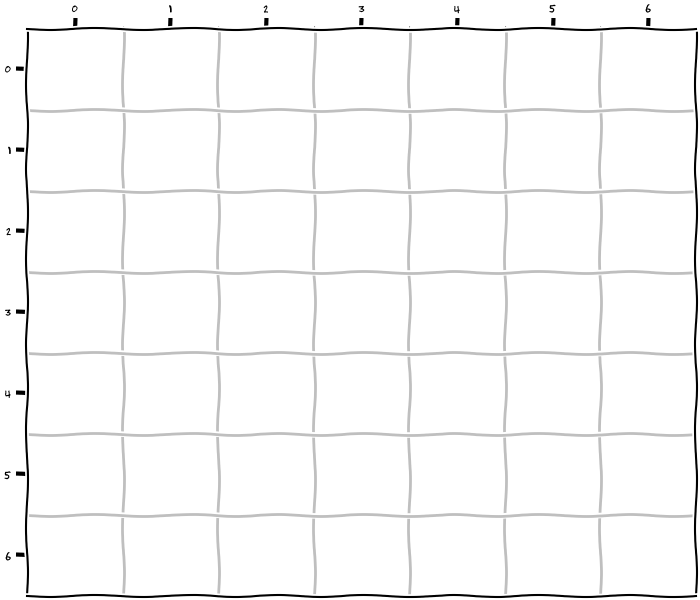

In [10]:
# to_remove solution

with plt.xkcd():
  fig, ax = make_grid(7, 7)

*Bonus*: Tweak the make_grid function in the Plotting Functions cell above to make the grid lines green.

Wow, what a boring environment. Let's add an organism and something for that organism to interact with. We'll start with 10 food items scattered randomly throughout the grid, never more than one food item per cell. To plot these food items we need their locations. We will set these by randomly sampling grid coordinates [without replacement](## "never picking the same (row,col) coordinate pair twice"). We'll place the organism in the same way and not on a food item to start.

In [11]:
################################################################################
# TODO for students: replace ... in init_loc(...) to initialize the right
# number of food item locations and critter locations in coordinates that make
# sense for our grid environment. Then replace the ... in rc_plotting[...] to
# index the plotting coordinates for the food locations.
# then comment out or remove the next line.
raise NotImplementedError("Exercise: initialize food and critter locations")
################################################################################
def init_loc(n_rows, n_cols, num):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int
    n_cols: int
    num:    int, wnumber of samples to generate, should
            throw an error ifnum <= n_rows x n_cols

  Returns:
    int_loc: ndarray(int) of flat indices for a grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in the way that matplotlib likes
  """
  int_loc = np.random.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.array(rc_index).T
  return int_loc, rc_index, rc_plotting


with plt.xkcd():
  fig, ax = make_grid(7, 7)
  int_locs, rc_index, rc_plotting = init_loc(...)

  rc_critter = (rc_plotting[0])
  plot_critter(fig, ax, rc_critter)

  rc_food = rc_plotting[...]
  plot_food(fig, ax, rc_food)

  fig.legend(loc='outside right upper')

NotImplementedError: ignored

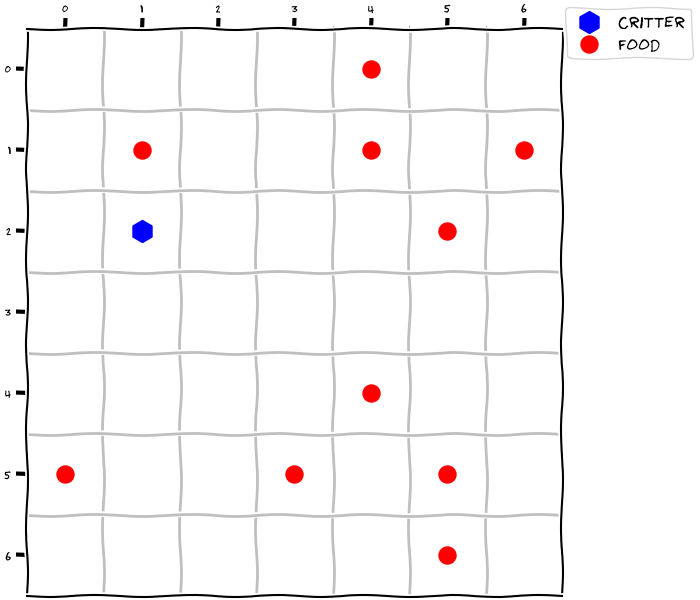

In [12]:
#to_remove solution


def init_loc(n_rows, n_cols, num):
  """
  Samples random 2d grid locations without replacement

  Args:
    n_rows: int
    n_cols: int
    num:    int, wnumber of samples to generate, should
            throw an error ifnum <= n_rows x n_cols

  Returns:
    int_loc: ndarray(int) of flat indices for a grid
    rc_index: (ndarray(int), ndarray(int)) a pair of arrays the first
      giving the row indices, the second giving the col indices, useful
      for indexing an n_rows by n_cols numpy array
    rc_plotting: ndarray(int) num x 2, same rc coordinates but structured
      in the way that matplotlib likes
  """
  int_loc = np.random.choice(n_rows * n_cols, num, replace=False)
  rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
  rc_plotting = np.array(rc_index).T
  return int_loc, rc_index, rc_plotting


with plt.xkcd():
  fig, ax = make_grid(7, 7)
  int_locs, rc_index, rc_plotting = init_loc(7, 7, 11)

  rc_critter = (rc_plotting[0])
  plot_critter(fig, ax, rc_critter)

  rc_food = rc_plotting[1:]
  plot_food(fig, ax, rc_food)

  fig.legend(loc='outside right upper')

In [13]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 1")

---
# Micro 1.1.1.2: Random Eating

Now that we have an environment scattered with food and an organism, let's introduce some behaviour. The organism drifts around the environment randomly and eats the food it happens to stumble upon. (Can you think of any organisms that employ this strategy?). When food is eaten, the organism gets a **reward**, in this case a *Food Eaten* point, and a new food item appears randomly somewhere else in the environment (that doesn't already have food). Run the code cell below to see what this looks like.

In [14]:
# @title Random Movement
# @markdown You don't need to worry about how this code works, yet – just **run this cell** and the one below for now and watch what happens

gwg = GridworldGame(1, 7, 7, 10, 30)
random_igwg = InteractiveGridworld(gwg)
display(random_igwg.b_fig.canvas)
clear_output()
display(random_igwg.board_output_and_score)

In [15]:
# @markdown Run this cell again to watch the random organism play
for ii in range(30):
  time.sleep(0.1)
  random_igwg.random_click()

*Question:* When the organism is just drifting around randomly how good is it at eating lots of food, what is its efficiency in terms of food per movement? Now run the cell above a few more times. Does the organism always eat the same amount of food or does it change between simulation runs?

In [17]:
# to_remove explanation

"""
The amount of food eaten varies a lot from simulation run to simulation run,
usually it manages to eat one or two pieces of food, sometimes more
sometimes less.
"""

'\nThe amount of food eaten varies a lot from simulation run to simulation run,\nusually it manages to eat one or two pieces of food, sometimes more \nsometimes less. \n'

Before we move on it's important to test that our simulation is running as we expect. Randomness can make testing hard, but can overcome in part by setting up the environment in such a way that the outcome becomes deterministic. In the two cells bellow change how the the Gridworld is initialized. By altering the size, shape and number of food items available create a scenario where the organism will always achieve perfect efficiency and a scenario where the organism will fail completely.

In [19]:
###############################################################################
# TODO for students: replace the ...'s in GridworldGame(...) to initialize a
# grid world where the organism is always 100% efficient.
raise NotImplementedError("Exercise: make random movement 100% efficient")
################################################################################

gwg = GridworldGame(1, ..., ..., ..., 30)
random_igwg_100 = InteractiveGridworld(gwg)
display(random_igwg_100.b_fig.canvas)
clear_output()
display(random_igwg_100.board_output_and_score)

NotImplementedError: ignored

In [20]:
#to_remove solution
gwg = GridworldGame(1, 2, 2, 3, 30)
random_igwg_100 = InteractiveGridworld(gwg)
display(random_igwg_100.b_fig.canvas)
clear_output()
display(random_igwg_100.board_output_and_score)

In [21]:
for ii in range(30):
  time.sleep(0.1)
  random_igwg_100.random_click()

In [23]:
###############################################################################
# TODO for students: replace the ...'s in GridworldGame(...) to initialize a
# grid world where the organism is always 0% efficient.
raise NotImplementedError("Exercise: make random movement 0% efficient")
################################################################################

gwg = GridworldGame(1, ..., ..., ..., 30)
random_igwg_0 = InteractiveGridworld(gwg)
display(random_igwg_0.b_fig.canvas)
clear_output()
display(random_igwg_0.board_output_and_score)

NotImplementedError: ignored

In [24]:
#to_remove solution
gwg = GridworldGame(1, 2, 2, 0, 30)
random_igwg_0 = InteractiveGridworld(gwg)
display(random_igwg_0.b_fig.canvas)
clear_output()
display(random_igwg_0.board_output_and_score)

In [25]:
for ii in range(30):
  random_igwg_0.random_click()
  time.sleep(0.1)

In [26]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 2")

---
# Micro 1.1.1.3: Better Than Random Eating
Now it's your turn to control the organism. Run the next cell and see how much more efficient than random drifting your control of the organism is in terms of food per movement.

In [27]:
# @title Controlled Movement
# @markdown You don't need to worry about how this code works – just **run the cell** and then use the buttons to guide the organism

# user in control
gwg = GridworldGame(1, 7, 7, 10, 30)
user_control_igwg = InteractiveGridworld(gwg)
display(user_control_igwg.b_fig.canvas)
clear_output()
display(user_control_igwg.boards_buttons_and_score)

Hopefully your performance was more successful than random flailing. Even in this relatively simple and contrived foraging scenario intelligence can help a lot. What kinds of strategies and heuristics did you use to guide your choice of direction? Essentially, the fundamental purpose of a nervous system and a brain is to solve problems of this kind—deciding which actions to take based on environmental inputs to maximize rewards.

In [28]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 3")

---
# Micro 1.1.1.4: Optimal Eating
Finally we'd like to introduce a time traveling super organism, GW7x7-10-30, from the last chapter of this book. GW7x7-10-30 has absolutely mastered 7x7 Gridworld, with 10 food items and a 30 round duration. Run the next cell and see how efficient a highly optimized and specialized Gridworld organism can be. Are you as good as gw7x7-10-30? If not, you gotta read this book 😉 (If you can't beat the AIs, at least learn how to program them.)

(Last chapter not made yet so working on a minimal sketch/skeleton version to produce this agent)
Several options on how to host/load the model

1) In the RL NMA tutorial, looks like they used to clone a github repo and pull files directly from there but now looks like they are downloading a snapshot of the repo hosted on open science foundation

```
#!git clone git://github.com/raymondchua/nma_rl_games.git --quiet
REPO_PATH = 'nma_rl_games'

if not os.path.exists(REPO_PATH):
  download_string = "Downloading"
  zipurl = 'https://osf.io/kf4p9/download'
  print(f"{download_string} and unzipping the file... Please wait.")
  with urlopen(zipurl) as zipresp:
    with zipfile.ZipFile(io.BytesIO(zipresp.read())) as zfile:
      zfile.extractall()
  print("Download completed.")

# add the repo in the path
sys.path.append('nma_rl_games/alpha-zero')
print(f"Added the {REPO_PATH} in the path and imported the modules.")

```

But looks like NMA is moving to hosting on open science foundation

```
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']
```

I think eventually we want to do something like hosting more directly on the open science foundation, but for now, using small file sizes we will download files directly from the repo using requests

In [33]:
gwg = GridworldGame(1, 7, 7, 10, 30)
pvnetMC = PolicyValueNetwork(gwg)
mcp = MonteCarloBasedPlayer(gwg, pvnetMC, default_depth=10,
                            default_rollouts=80, default_temp=0.1)

In [34]:
url = "https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C1_BehaviourAsPolicy/data/pvnetMC.pth.tar"
r = requests.get(url)

if r.status_code == 200:
  filename = os.path.basename(url)
  # Write the contents to a file in the current working directory
  with open(filename, 'wb') as file:
    file.write(r.content)
    #print(f'{filename} downloaded successfully.')
else:
  print('Error occurred while downloading the file.')

pvnetMC.load_checkpoint(folder=os.getcwd(), filename='pvnetMC.pth.tar')

In [35]:
optimal_igwg = InteractiveGridworld(gwg)
display(optimal_igwg.b_fig.canvas)
clear_output()
display(optimal_igwg.board_output_and_score)

In [36]:
mcp.play(optimal_igwg.board_state)

(array([2]),
 array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]]),
 array([[0.00000000e+00, 0.00000000e+00, 9.98450949e-01, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.32991461e-03, 0.00000000e+00, 2.09758434e-04, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         9.37835510e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+0

In [ ]:
# @title Optimal Movement
# @markdown You don't need to worry about how this code works – just **run the cell** to watch the super organism behave. See if you can outperform them.

# master organism in control

In [ ]:
# @markdown Vibe Check
content_review("Sequence 1.1.1 Micro 4")

---
# Graveyard


Useful scavenging from github and SO

In [ ]:
from matplotlib import animation, rc, patches
from IPython.display import HTML

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xticks(np.arange(0, 11, 1))
ax.set_yticks(np.arange(0, 11, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, 11, 1))
ax.set_yticklabels(np.arange(0, 11, 1))

# Minor ticks
ax.set_xticks(np.arange(1.5, 10.5, 1), minor=True)
ax.set_yticks(np.arange(1.5, 10.5, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

ax.set_xlim(( 0.5, 10.5))
ax.set_ylim(( 0.5, 10.5))

#ax.axis("equal")
scatter = ax.scatter([], [])
#critterCircle = plt.Circle((5,5), 0.4)
#dot = ax.add_patch(critterCircle)
#scatter.set_offsets([[5, 5]])

scatter.set_offsets([[3, 11-3]])
#fig.canvas.draw()
#fig.canvas.flush_events()

In [ ]:
def init():
    scatter.set_offsets([[5, 5]])
    return scatter,

In [ ]:
def animate_dot(i):
    print(i)
    x = i
    y = 11-i
    scatter.set_offsets([[x, y]])
    return scatter,

In [ ]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate_dot, init_func=init,
                               frames=(np.arange(10)+1), interval=500, blit=True)

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
rc('animation', html='html5')

In [ ]:
anim

These movies are a bit slicker than drawing using the matplotlib figure canvas updates, is this something we can/should incorporate into the non-interactive versions where you just watch something play.

Thoughts to tweak the game, have random movement be something that always happens and directed movement as an optional intervention, maybe on a timer?

